## Entrenamiento de VGG usando CIFAR10 (from scratch)
CIFAR10 es un conjunto de datos etiquetados de imágenes pequeñas, contiene 60000 imágenes de colores de 32x32 divididas en 10 classes, son 6000 imágenes por clase. Hay 50000 imágenes de entrenamiento y 10000 imágenes de prueba. 
Adaptado de:
- http://cv-tricks.com/tensorflow-tutorial/training-convolutional-neural-network-for-image-classification/
- http://goo.gl/B68jj1

### 1. Descargar, preprocesar y generar iterables para CIFAR10 (train & test)

In [1]:
from skdata.cifar10.dataset import CIFAR10
import numpy as np
import itertools as it

def batch_iterator(iterable, size, cycle=False, batch_fn=lambda x: x):
    """
    Generador en lotes de una lista o de un objeto iterable
    """
    batch = []

    if cycle is True:
        # volver al inicio
        iterable = it.cycle(iterable)

    # iterar sobre todos los elementos de la lista/iterable
    for item in iterable:
        batch.append(item)
        if len(batch) >= size:
            # generamos un lote de #_size_ elementos
            yield batch_fn(batch)
            batch = []

    if len(batch) > 0:
        # si hay restantes, para el último lote
        yield batch_fn(batch)


def get_cifar10(batch_size=16):
    print("cargando CIFAR10...")
   
    # dejemos a la librería skdata hacer su trabajo
    cifar10 = CIFAR10()
    cifar10.fetch(True)

    # cargamos toda la data en memoria 
    # entrenamiento:
    trn_labels = []
    trn_pixels = []
    for i in range(1, 6):
        data = cifar10.unpickle("data_batch_%d" % i)
        trn_pixels.append(data['data'])
        trn_labels.extend(data['labels'])
    trn_pixels = np.vstack(trn_pixels)
    trn_pixels = trn_pixels.reshape(-1, 3, 32, 32).astype(np.float32)
    # validación:
    tst_data = cifar10.unpickle("test_batch")
    tst_labels = tst_data["labels"]
    tst_pixels = tst_data["data"]
    tst_pixels = tst_pixels.reshape(-1, 3, 32, 32).astype(np.float32)

    # print("trn.shape=%s tst.shape=%s" % (trn_pixels.shape, tst_pixels.shape))

    print("estandarizando CIFAR10...")
    mu = np.mean(trn_pixels, axis=(0, 2, 3))
    std = np.std(trn_pixels, axis=(0, 2, 3))
    print("CIFAR10 mu  = %s" % mu)
    print("CIFAR10 std = %s" % std)    
    # x' = (x - u) / s
    trn_pixels[:, :, :, :] -= mu.reshape(1, 3, 1, 1)
    trn_pixels[:, :, :, :] /= std.reshape(1, 3, 1, 1)    
    tst_pixels[:, :, :, :] -= mu.reshape(1, 3, 1, 1)
    tst_pixels[:, :, :, :] /= std.reshape(1, 3, 1, 1)

    # usar orden de tensorflow: b x height x widht x canales
    trn_pixels = trn_pixels.transpose(0, 2, 3, 1)
    tst_pixels = tst_pixels.transpose(0, 2, 3, 1)
    
    print("trn_pixels", trn_pixels.shape)
    print("tst_pixels", tst_pixels.shape)

    # generador en lotes para la data de entrenamiento 
    trn_set = batch_iterator(it.cycle(zip(trn_pixels, trn_labels)), batch_size, cycle=True, batch_fn=lambda x: zip(*x))    
    # generador en lotes para la data de validación
    tst_set = batch_iterator(it.cycle(zip(tst_pixels, tst_labels)), batch_size, cycle=True, batch_fn=lambda x: zip(*x))    
    return trn_set, tst_set


/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 2. Definir la arquitectura del modelo y el proceso de entrenamiento

In [2]:
import tensorflow as tf


def conv_op(input_op, name, kw, kh, n_out, dw, dh):
    '''
    capa convolucional 
    kw, kw: kernel
    dw, dh: stride
    n_out: profundidad / número de filtros
    '''
    n_in = input_op.get_shape()[-1].value

    with tf.name_scope(name) as scope:
        kernel = tf.get_variable(scope + "w",
                                 shape=[kh, kw, n_in, n_out],
                                 dtype=tf.float32,
                                 initializer=tf.contrib.layers.xavier_initializer_conv2d())
        conv = tf.nn.conv2d(input_op, kernel, (1, dh, dw, 1), padding='SAME')
        bias_init_val = tf.constant(0.0, shape=[n_out], dtype=tf.float32)
        biases = tf.Variable(bias_init_val, trainable=True, name='b')
        z = tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape())
        activation = tf.nn.relu(z, name=scope)
        return activation


def fc_op(input_op, name, n_out):
    '''
    capa densa o completamente conectada
    '''
    n_in = input_op.get_shape()[-1].value

    with tf.name_scope(name) as scope:
        kernel = tf.get_variable(scope + "w",
                                 shape=[n_in, n_out],
                                 dtype=tf.float32,
                                 initializer=tf.contrib.layers.xavier_initializer())
        biases = tf.Variable(tf.constant(0.1, shape=[n_out], dtype=tf.float32), name='b')
        activation = tf.nn.relu_layer(input_op, kernel, biases, name=scope)
        return activation


def mpool_op(input_op, name, kh, kw, dh, dw):
    '''
    pooling
    '''
    return tf.nn.max_pool(input_op,
                          ksize=[1, kh, kw, 1],
                          strides=[1, dh, dw, 1],
                          padding='SAME',
                          name=name)


def loss_op(logits, labels, batch_size):
    '''
    calculamos el costo usando cross-entropy loss para clases mutuamente exclusivas
    se busca minimizar el resultado de esta operación
    https://rdipietro.github.io/friendly-intro-to-cross-entropy-loss/
    '''
    labels = tf.expand_dims(labels, 1)
    indices = tf.expand_dims(tf.range(0, batch_size, 1), 1)
    print(labels.shape)
    print(indices.shape)
    concated = tf.concat([indices, labels], 1)
    onehot_labels = tf.sparse_to_dense(concated, np.asarray([batch_size, 10]), 1.0, 0.0)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=onehot_labels, name='xentropy')
    loss = tf.reduce_mean(cross_entropy, name='xentropy_mean')
    return loss


def evaluate_op(predictions, labels):
    '''
    evaluando la calidad de las predicciones
    retorna el número de predicciones correctas
    '''    
    # array de booleanos verdadero si predictions[i]=labels[i]
    correct = tf.nn.in_top_k(predictions, labels, 1)
    total_correct = tf.reduce_sum(tf.cast(correct, tf.int32))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    return accuracy, total_correct


def inference_cifar10_vgg(input_op):
    '''
    construimos el modelo VGG-B con las siguientes modificaciones:
    - la entrada es de 128x128 no de 224x224
    - el bloque #4 tiene 1 capa adicional
    - se ignora el bloque #5 
    - las capas completamente conectadas de 100 y no de 4096
    - se añade dropout entre las capas completamente conectadas
    - la última capa completamente conectada de 10 y no de 1000
    '''
    
    #dropout_keep_prob = 1.0 if training else 1.0
    dropout_keep_prob = 1.0
    
    # bloque 1 -- salida 112x112x64
    conv1_1 = conv_op(input_op, name="conv1_1", kh=3, kw=3, n_out=16, dh=1, dw=1)
    conv1_2 = conv_op(conv1_1, name="conv1_2", kh=3, kw=3, n_out=16, dh=1, dw=1)
    pool1 = mpool_op(conv1_2, name="pool1", kh=2, kw=2, dw=2, dh=2)

    # bloque 2 -- salida 56x56x128
    conv2_1 = tf.nn.dropout(conv_op(pool1, name="conv2_1", kh=3, kw=3, n_out=32, dh=1, dw=1), dropout_keep_prob)
    conv2_2 = tf.nn.dropout(conv_op(conv2_1, name="conv2_2", kh=3, kw=3, n_out=32, dh=1, dw=1), dropout_keep_prob)
    pool2 = mpool_op(conv2_2, name="pool2", kh=2, kw=2, dh=2, dw=2)

    # bloque 3 -- salida 28x28x256
    conv3_1 = tf.nn.dropout(conv_op(pool2, name="conv3_1", kh=3, kw=3, n_out=64, dh=1, dw=1), dropout_keep_prob)
    conv3_2 = tf.nn.dropout(conv_op(conv3_1, name="conv3_2", kh=3, kw=3, n_out=64, dh=1, dw=1), dropout_keep_prob)
    pool3 = mpool_op(conv3_2, name="pool3", kh=2, kw=2, dh=2, dw=2)

    # bloque 4 -- salida 14x14x512
    conv4_1 = tf.nn.dropout(conv_op(pool3, name="conv4_1", kh=3, kw=3, n_out=128, dh=1, dw=1), dropout_keep_prob)
    conv4_2 = tf.nn.dropout(conv_op(conv4_1, name="conv4_2", kh=3, kw=3, n_out=128, dh=1, dw=1), dropout_keep_prob)
    conv4_3 = tf.nn.dropout(conv_op(conv4_2, name="conv4_3", kh=3, kw=3, n_out=128, dh=1, dw=1), dropout_keep_prob)
    pool4 = mpool_op(conv4_3, name="pool4", kh=2, kw=2, dh=2, dw=2)

    # bloque 5 -- por motivos de celeridad se ignora el bloque 5
    # IGNORADO
    
    # flatten
    shp = pool4.get_shape()
    flattened_shape = shp[1].value * shp[2].value * shp[3].value
    resh1 = tf.reshape(pool4, [-1, flattened_shape], name="resh1")

    # capas completamente conectadas
    fc6 = fc_op(resh1, name="fc6", n_out=100)
    fc6_drop = tf.nn.dropout(fc6, dropout_keep_prob, name="fc6_drop")

    fc7 = fc_op(fc6_drop, name="fc7", n_out=100)
    fc7_drop = tf.nn.dropout(fc7, dropout_keep_prob, name="fc7_drop")

    fc8 = fc_op(fc7_drop, name="fc8", n_out=10)
    softmax = tf.nn.softmax(fc8, name="y_pred")
    predictions = tf.argmax(softmax, 1)
    return predictions, softmax, fc8


# entrenamiento basado en:
# http://cv-tricks.com/tensorflow-tutorial/training-convolutional-neural-network-for-image-classification/
def train(trn_generator,
          val_generator,
          trn_size,
          val_size,
          lr=0.01,
          nb_epochs=10,
          batch_size=100,
          training_log_path="train_log.csv",
          model='model'):

    with tf.Graph().as_default():

        # las imágenes son reducidas al tamaño de entrada del modelo
        raw_images = tf.placeholder("float", [batch_size, 32, 32, 3], name='x')
        images = tf.image.resize_images(raw_images, [128, 128])
        labels = tf.placeholder("int32", [batch_size], name='y_true')
        
        # el modelo de la red
        predictions, softmax, logits = inference_cifar10_vgg(images)
        
        # la función objetivo a minimizar (costo)
        cost = loss_op(logits, labels, batch_size)
        
        # la métrica de evaluación
        accuracy, total_correct = evaluate_op(softmax, labels)
        
        # el algoritmo de aprendizaje, también pudo ser: optimizer = tf.train.AdamOptimizer(lr)
        global_step = tf.Variable(0, name="global_step", trainable=False)  # contador para los batches        
        optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost, global_step=global_step)

        saver = tf.train.Saver()
        
        # iniciando entrenamiento
        with tf.Session() as session:
            session.run(tf.global_variables_initializer())

            training_log = open(training_log_path, "w")
            training_log.write("trn_acc,trn_loss,val_acc,val_loss\n")

            for epoch in range(nb_epochs):
                for step in range(trn_size//batch_size):
                    # siguiente lote de datos de entrenamiento
                    x_batch, y_true_batch = list(trn_generator.__next__())
                    feed_dict_trn = {raw_images: x_batch, labels: y_true_batch}
                    
                    session.run(optimizer, feed_dict=feed_dict_trn)
                    
                    if step % (val_size//batch_size) == 0:
                        # siguiente lote de datos de validación
                        x_val_batch, y_val_batch = list(val_generator.__next__())
                        feed_dict_val = {raw_images: x_val_batch, labels: y_val_batch}
                        
                        trn_acc = session.run(accuracy, feed_dict=feed_dict_trn)
                        trn_loss = session.run(cost, feed_dict=feed_dict_trn) 
                        val_acc = session.run(accuracy, feed_dict=feed_dict_val)
                        val_loss = session.run(cost, feed_dict=feed_dict_val)
                        
                        msg = "Epoch {0}.{1} --- trn_acc:{2:>6.1%}, val_acc: {4:>6.1%}, trn_loss: {3:.3f}, val_loss: {5:.3f}"
                        print(msg.format(epoch + 1, step//batch_size, trn_acc, trn_loss, val_acc, val_loss))
                        
                        saver.save(session, model) 

                        training_log.write("%s,%s,%s,%s\n" % (trn_acc, trn_loss, val_acc, val_loss))


### 3. Ejecutar el entrenamiento

In [3]:
batch_size = 100
model_file = 'vgg16-model'
log_file = 'vgg16-log.csv'
trn_generator, val_generator = get_cifar10(batch_size=batch_size)

cargando CIFAR10...
estandarizando CIFAR10...
CIFAR10 mu  = [ 125.30690002  122.95014954  113.86599731]
CIFAR10 std = [ 62.9932518   62.08860397  66.70500946]
trn_pixels (50000, 32, 32, 3)
tst_pixels (10000, 32, 32, 3)


In [8]:
# 50000 train images
# 10000 test images
# si no se usa dropout en la época 10 empieza a sobreentrenarse
train(trn_generator, val_generator,
      50000, 10000, batch_size=batch_size,
      lr=0.01, nb_epochs=10, model=model_file, training_log_path=log_file)

(100, 1)
(100, 1)
Epoch 1.0 --- trn_acc: 13.0%, val_acc:   8.0%, trn_loss: 2.313, val_loss: 2.324
Epoch 1.1 --- trn_acc:  8.0%, val_acc:  10.0%, trn_loss: 2.291, val_loss: 2.292
Epoch 1.2 --- trn_acc: 20.0%, val_acc:  28.0%, trn_loss: 2.242, val_loss: 2.233
Epoch 1.3 --- trn_acc: 27.0%, val_acc:  26.0%, trn_loss: 1.981, val_loss: 2.100
Epoch 1.4 --- trn_acc: 25.0%, val_acc:  31.0%, trn_loss: 2.036, val_loss: 1.970
Epoch 2.0 --- trn_acc: 35.0%, val_acc:  23.0%, trn_loss: 1.837, val_loss: 2.065
Epoch 2.1 --- trn_acc: 39.0%, val_acc:  29.0%, trn_loss: 1.747, val_loss: 1.848
Epoch 2.2 --- trn_acc: 42.0%, val_acc:  32.0%, trn_loss: 1.665, val_loss: 1.899
Epoch 2.3 --- trn_acc: 48.0%, val_acc:  41.0%, trn_loss: 1.541, val_loss: 1.714
Epoch 2.4 --- trn_acc: 46.0%, val_acc:  42.0%, trn_loss: 1.634, val_loss: 1.628
Epoch 3.0 --- trn_acc: 46.0%, val_acc:  42.0%, trn_loss: 1.487, val_loss: 1.661
Epoch 3.1 --- trn_acc: 50.0%, val_acc:  38.0%, trn_loss: 1.414, val_loss: 1.686
Epoch 3.2 --- trn_acc:

### 4.1 Pérdida y precisión del entrenamiento (15 épocas/no dropout/1000 fc)

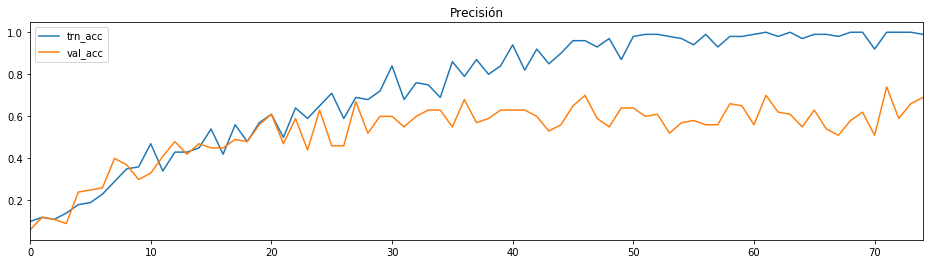

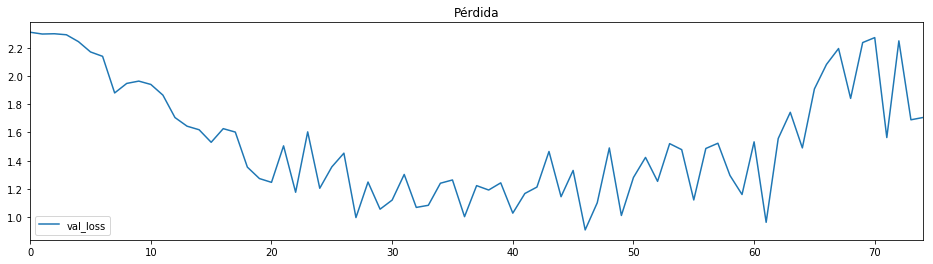

In [9]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('train_log_10k.csv')
df.plot(y=['trn_acc', 'val_acc'], figsize=(16,4), title='Precisión')

#df.plot(y=['trn_loss'], figsize=(16,4), title='Train Loss')
df.plot(y=['val_loss'], figsize=(16,4), title='Pérdida')


### 4.2 Pérdida y precisión del entrenamiento (10 épocas/no dropout/100 fc)

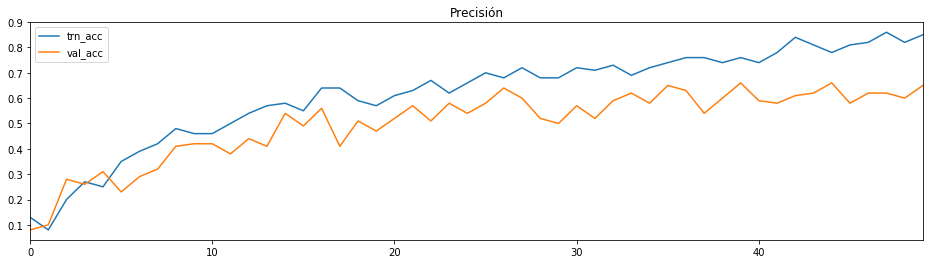

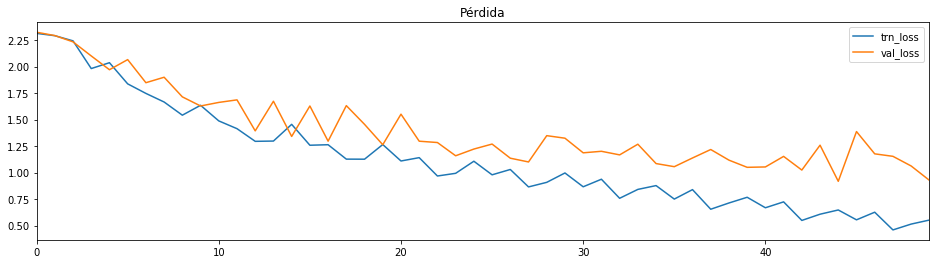

In [10]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(log_file)
df.plot(y=['trn_acc', 'val_acc'], figsize=(16,4), title='Precisión')
df.plot(y=['trn_loss', 'val_loss'], figsize=(16,4), title='Pérdida')


### 5. Cargar el modelo y realizar predicciones

In [14]:
with tf.Session() as session:
    # Cargar el modelo: grafo y pesos
    saver = tf.train.import_meta_graph(model_file + '.meta')
    saver.restore(session, tf.train.latest_checkpoint('./'))

    # grafo por defecto
    graph = tf.get_default_graph()

    # tensor que realiza la predicción
    y_pred = graph.get_tensor_by_name("y_pred:0")

    # tensores de entrada para la red
    x = graph.get_tensor_by_name("x:0") 
    y_true = graph.get_tensor_by_name("y_true:0") 

    # un batch de la data de validación
    x_val_batch, y_val_batch = list(val_generator.__next__())
    feed_dict_testing = {x: x_val_batch, y_true: y_val_batch}
    result = session.run(y_pred, feed_dict=feed_dict_testing)

    print(result[0])
    print(y_val_batch[0])

INFO:tensorflow:Restoring parameters from ./vgg16-model
[  6.01349224e-04   8.19580793e-01   1.84687972e-03   1.18655153e-03
   2.72250996e-04   1.70766679e-03   2.72250996e-04   2.92907382e-04
   4.08076793e-02   1.33431569e-01]
1
